In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [1]:
!ls '/gdrive/My Drive/datasets/'

aclImdb		     cats_and_dogs_small_1.h5  cats_and_dogs_small_4.h5
cats_and_dogs	     cats_and_dogs_small_2.h5  gan_images
cats_and_dogs_small  cats_and_dogs_small_3.h5  jena_climate


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 컨브넷의 학습 시각화하기


* 컨브넷 중간 층의 출력(중간 층에 있는 활성화)을 시각화하기 
* 컨브넷 필터를 시각화하기 
* 클래스 활성화에 대한 히트맵을 이미지에 시각화하기 

## 중간 층의 활성화 시각화하기 

In [3]:
!pip install h5py

In [4]:
from keras.models import load_model
import os 

base_root_dir = '/gdrive/My Drive/datasets/'
model = load_model(os.path.join(base_root_dir,'cats_and_dogs_small_2.h5'))
#model = load_model('cats_and_dogs_small_2.h5')
model.summary()  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_______________________________________

그다음 네트워크를 훈련할 때 사용했던 이미지에 포함되지 않은 고양이 사진 하나를 입력 이미지로 선택합니다:

In [5]:
# img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'
img_path = os.path.join(base_root_dir) + '/cats_and_dogs_small/test/cats/cat.1700.jpg'

# 이미지를 4D 텐서로 변경합니다
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용합니다
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)입니다
print(img_tensor.shape)

(1, 150, 150, 3)


In [0]:
import matplotlib.pyplot as plt

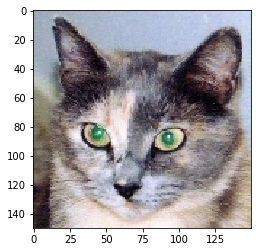

In [7]:
plt.imshow(img_tensor[0])
plt.show()

확인하고 싶은 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델을 만들 것입니다.

* 케라스의 `Model` 클래스를 사용
* 매개변수: 입력 텐서(또는 입력 텐서의 리스트)와 출력 텐서(또는 출력 텐서의 리스트)
* 반환되는 객체: 케라스 모델이지만 특정 입력과 특정 출력을 매핑하여 `Sequential`과는 달리 여러 개의 출력을 가진 모델을 만들 수 있습니다. 

In [0]:
from keras import models

# 상위 8개 층의 출력을 추출
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듬
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [18]:
for layer in model.layers[:8]:
  print(layer.output)

Tensor("conv2d_5/Relu:0", shape=(?, 148, 148, 32), dtype=float32)
Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 74, 74, 32), dtype=float32)
Tensor("conv2d_6/Relu:0", shape=(?, 72, 72, 64), dtype=float32)
Tensor("max_pooling2d_6/MaxPool:0", shape=(?, 36, 36, 64), dtype=float32)
Tensor("conv2d_7/Relu:0", shape=(?, 34, 34, 128), dtype=float32)
Tensor("max_pooling2d_7/MaxPool:0", shape=(?, 17, 17, 128), dtype=float32)
Tensor("conv2d_8/Relu:0", shape=(?, 15, 15, 128), dtype=float32)
Tensor("max_pooling2d_8/MaxPool:0", shape=(?, 7, 7, 128), dtype=float32)


이 모델은 하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가집니다.

In [0]:
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환
activations = activation_model.predict(img_tensor)

예를 들어 다음이 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값입니다:

In [10]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

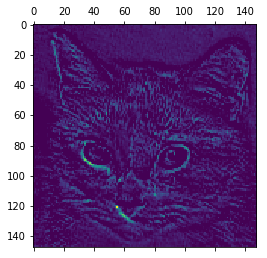

In [11]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

이 채널은 대각선 에지를 감지하도록 인코딩된 것 같습니다. 열여섯 번째 채널을 그려보죠. 합성곱 층이 학습한 필터는 결정적이지 않기 때문에 채널 이미지가 각자 다를 수 있습니다.

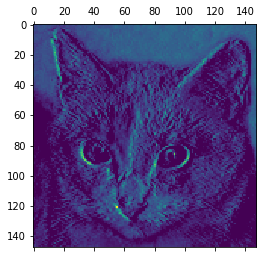

In [12]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

이 채널은 '밝은 녹색 점'을 감지하는 것 같아 고양이 눈을 인코딩하기 좋습니다. 이제 네트워크의 모든 활성화를 시각화해 보겠습니다. 8개의 활성화 맵에서 추출한 모든 채널을 그리기 위해 하나의 큰 이미지 텐서에 추출한 결과를 나란히 쌓겠습니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


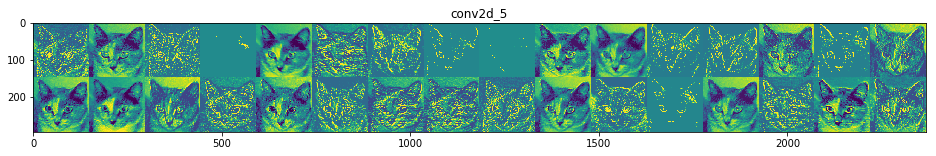

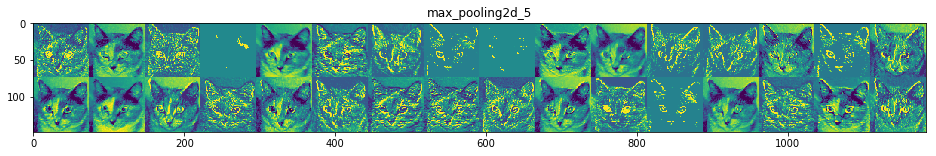

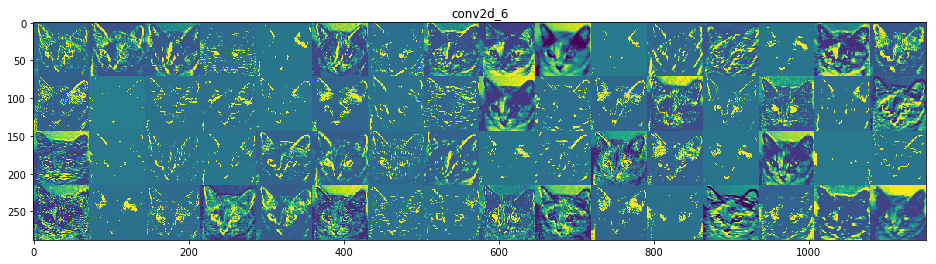

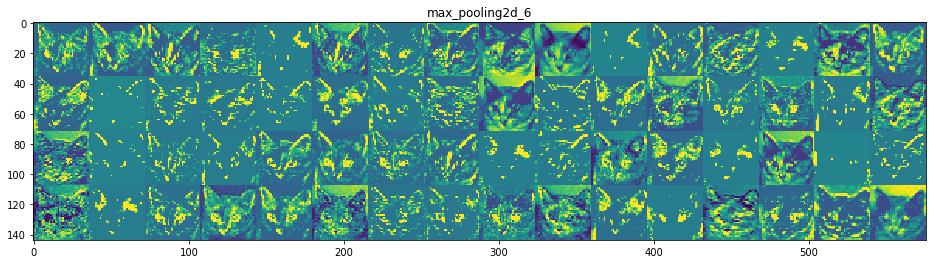

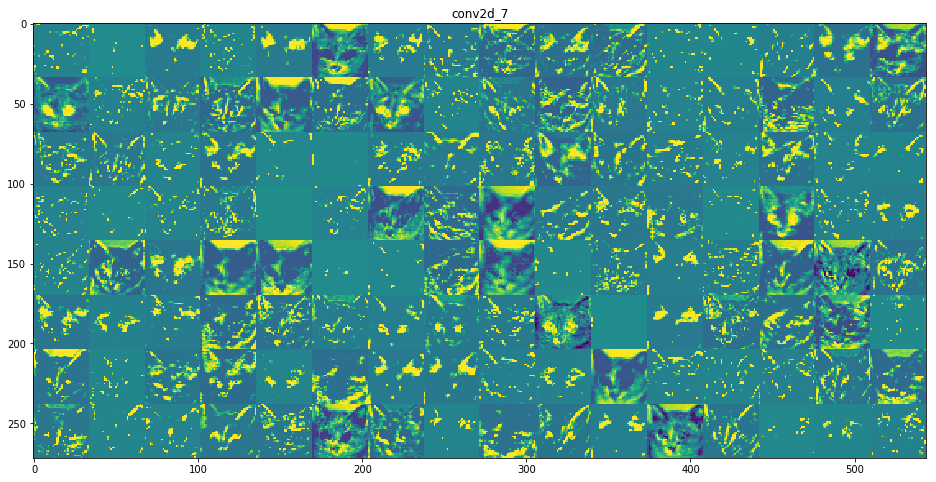

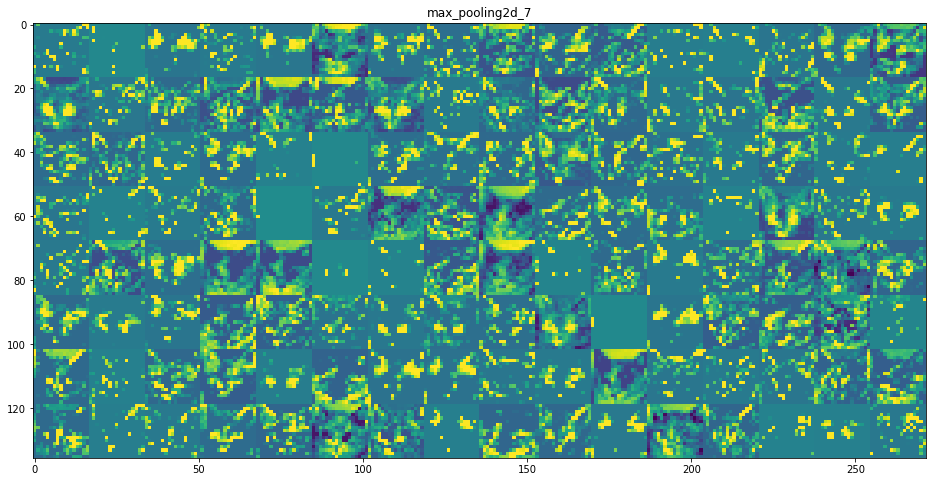

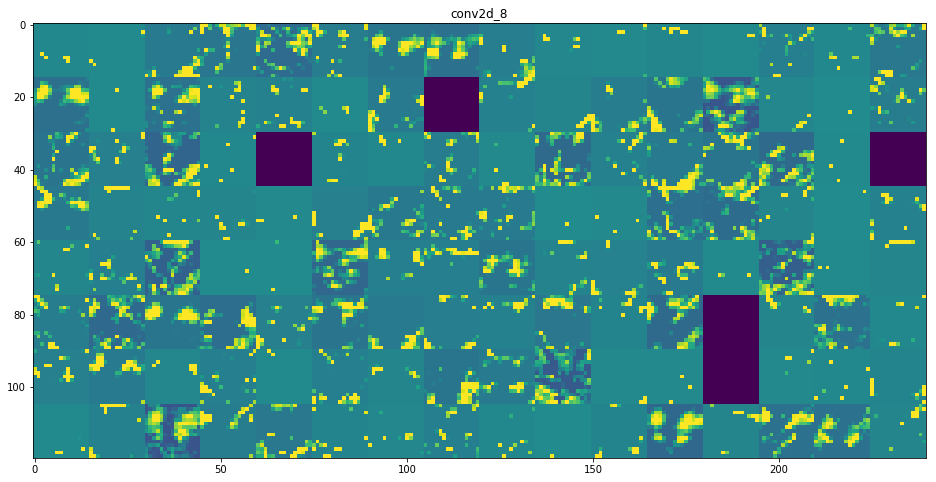

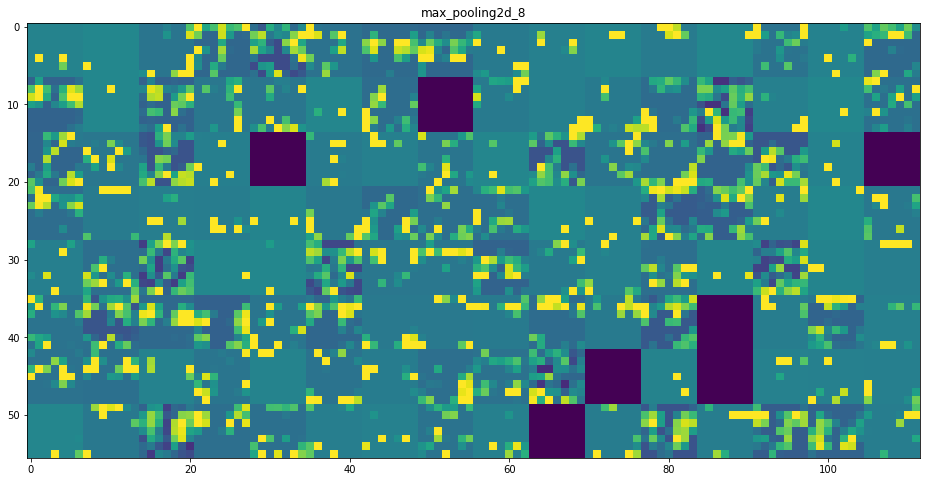

In [13]:
# 층의 이름을 그래프 제목으로 사용
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

* 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같습니다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됩니다.
* 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작합니다. 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가합니다.
* 비어 있는 활성화가 층이 깊어짐에 따라 늘어납니다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생깁니다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미입니다.